In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import anndata
from tools import add_labels, add_largedot_legend, log_transform, normalize_and_scale, pearson_residuals, sqrt_lazy, PCA_sklearn, kobak_tsne, run_glmpca, deviance_residuals

#### Some aesthetics

In [2]:
title_fontsize = 20
title_fontweight = "bold"
cmap = sns.cubehelix_palette(6, start=0.9, rot=0, dark=0.9, light=0.2, reverse=True,as_cmap=True)
xmean_label = 'expression mean'

# Compute normalization

#### Load dataset

In [3]:
folder = 'datasets/33k_pbmc/'
picklefile = folder+'preprocessed.pickle'
dataset = pickle.load(open(picklefile, "rb"))
print(dataset['counts'].shape)
dataset['labelshort'] = '10X v1 33k PBMC'
counts = dataset['counts'].toarray()

(33148, 16809)


#### Load sctransform results

In [4]:
with open('datasets/33k_pbmc/sctransform_pearson_residuals.pickle','rb') as f:
    sct_residuals_df = pickle.load(f)
dataset['sct_residuals'] = sct_residuals_df.values.T

#### Compute Pearson residuals

In [5]:
%time dataset['residuals_theta100'] = pearson_residuals(counts,100)
%time dataset['residuals_theta100_noclip'] = pearson_residuals(counts,100,clipping=False)
%time dataset['residuals_theta10'] = pearson_residuals(counts,10)
%time dataset['residuals_thetaInf'] = pearson_residuals(counts,np.Inf)

CPU times: user 9.15 s, sys: 4.06 s, total: 13.2 s
Wall time: 13.2 s
CPU times: user 8.5 s, sys: 1.03 s, total: 9.53 s
Wall time: 9.53 s
CPU times: user 9.45 s, sys: 1.02 s, total: 10.5 s
Wall time: 10.5 s
CPU times: user 9.44 s, sys: 1.03 s, total: 10.5 s
Wall time: 10.5 s


#### Compute Deviance residuals

In [6]:
%time dataset['deviance_residuals_theta100'] = deviance_residuals(counts,100)

CPU times: user 23.5 s, sys: 2.07 s, total: 25.5 s
Wall time: 25.5 s


#### Sqrt transform

In [7]:
%time dataset['sqrt_lazy'] = sqrt_lazy(counts)

CPU times: user 3.23 s, sys: 928 µs, total: 3.23 s
Wall time: 3.23 s


#### Log transform

In [8]:
%time dataset['normalized_medianscale'] = normalize_and_scale(counts,scale_mode='median')

CPU times: user 2.94 s, sys: 2.7 ms, total: 2.95 s
Wall time: 2.94 s


In [9]:
%time dataset['normalized'] = normalize_and_scale(counts,scale=1)
%time dataset['log1p_medianscale'] = log_transform(counts,scale_mode='median')
%time dataset['log1p_10kscale'] = log_transform(counts,scale=10000,scale_mode='user_provided_scale')

CPU times: user 2.53 s, sys: 3.63 ms, total: 2.53 s
Wall time: 2.53 s
CPU times: user 4.75 s, sys: 1.03 s, total: 5.78 s
Wall time: 5.78 s
CPU times: user 4.74 s, sys: 1.05 s, total: 5.8 s
Wall time: 5.79 s


#### Load GLM PCA results

In [10]:
with open('glmpca_results/glmpca_pbmc_nb_tol0.0001_raw.pickle',"rb") as f:
    glmpca_nb_raw = pickle.load(f)    
glmpca_fam_idx = int(np.where(np.array([n for n in glmpca_nb_raw.names])=='glmpca_family')[0][0])
nb_theta_idx = int(np.where(np.array([n for n in glmpca_nb_raw[glmpca_fam_idx].names])=='nb_theta')[0][0])
glmpca_nb_theta = list(glmpca_nb_raw[glmpca_fam_idx][nb_theta_idx])[0]

#### Load tSNEs

In [11]:
with open('tsne/tsne_pbmc_sqrt_lazy_initsqrtLazy.pickle','rb') as f:
    sqrt_lazy_tsne = pickle.load(f)
    
with open('tsne/tsne_pbmc_residuals_theta100_initsqrtLazy.pickle','rb') as f:
    residuals_theta100_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_residuals_theta10_initsqrtLazy.pickle','rb') as f:
    residuals_theta10_tsne = pickle.load(f)
    
with open('tsne/tsne_pbmc_glmpca_poi_tol10-8_initsqrtLazy.pickle','rb') as f:
    glmpca_poi_lowTol_tsne = pickle.load(f)    
with open('tsne/tsne_pbmc_glmpca_nb_initsqrtLazy.pickle','rb') as f:
    glmpca_nb_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_glmpca_nb_thetaFixed100_initsqrtLazy.pickle','rb') as f:
    glmpcaPy_nb_thetaFixed_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_glmpca_nb2_initsqrtLazy.pickle','rb') as f:
    glmpca_nb2_tsne = pickle.load(f)
    
with open('tsne/tsne_pbmc_normalized_initsqrtLazy.pickle','rb') as f:
    normalized_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_log1p_medianscale_initsqrtLazy.pickle','rb') as f:
    log1p_medianscale_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_log1p_10kscale_initsqrtLazy.pickle','rb') as f:
    log1p_10kscale_tsne = pickle.load(f)

# Gene selection

In [12]:
### Compute expression means and variances after transforms
gene_means = np.mean(counts,axis=0)
sqrt_lazy_var = np.var(dataset['sqrt_lazy'],axis=0)
residual_var = np.var(dataset['residuals_theta100'],axis=0)
residual_noclip_var = np.var(dataset['residuals_theta100_noclip'],axis=0)
residual_theta10_var = np.var(dataset['residuals_theta10'],axis=0)
residual_thetaInf_var = np.var(dataset['residuals_thetaInf'],axis=0)

devresidual_var = np.var(dataset['deviance_residuals_theta100'],axis=0)
sctresidual_var = np.var(dataset['sct_residuals'],axis=0)

### look at different scalings for log
normalized_var = np.var(dataset['normalized'],axis=0)
normmedian_var = np.var(dataset['normalized_medianscale'],axis=0)
log1p_medianscale_var = np.var(dataset['log1p_medianscale'],axis=0)
log1p_10kscale_var = np.var(dataset['log1p_10kscale'],axis=0)

In [13]:
##select 100 genes with each of the methods
sqrt_threshold = np.sort(sqrt_lazy_var)[-100] 
residuals_threshold = np.sort(residual_var)[-100]
residuals_noclip_threshold = np.sort(residual_noclip_var)[-100]
residuals_theta10_threshold = np.sort(residual_theta10_var)[-100]
residuals_thetaInf_threshold = np.sort(residual_thetaInf_var)[-100]

devresiduals_threshold = np.sort(devresidual_var)[-100]
sctresiduals_threshold = np.sort(sctresidual_var)[-100]
residuals_threshold1000 = np.sort(residual_var)[-1000]
sctresiduals_threshold1000 = np.sort(sctresidual_var)[-1000]


residuals_variable_genes_idx = residual_var >= residuals_threshold
residuals_variable_genes_idx1000 = residual_var >= residuals_threshold1000
residuals_variable_genes = dataset['genes'][residuals_variable_genes_idx]
sqrt_variable_genes_idx = sqrt_lazy_var >= sqrt_threshold
sqrt_variable_genes = dataset['genes'][sqrt_variable_genes_idx]
devresiduals_variable_genes_idx = devresidual_var >= devresiduals_threshold
devresiduals_variable_genes = dataset['genes'][devresiduals_variable_genes_idx]
sctresiduals_variable_genes_idx = sctresidual_var >= sctresiduals_threshold
sctresiduals_variable_genes_idx1000 = sctresidual_var >= sctresiduals_threshold1000
sctresiduals_variable_genes = dataset['genes'][sctresiduals_variable_genes_idx]

## prepare also for log methods
normalized_threshold = np.sort(normalized_var)[-100]
log1p_medianscale_threshold = np.sort(log1p_medianscale_var)[-100]
log1p_10kscale_threshold = np.sort(log1p_10kscale_var)[-100]

residuals_variable_genes_idx = residual_var >= residuals_threshold

normalized_variable_genes_idx = normalized_var >= normalized_threshold 
log1p_medianscale_variable_genes_idx = log1p_medianscale_var >= log1p_medianscale_threshold 
log1p_10kscale_variable_genes_idx = log1p_10kscale_var >= log1p_10kscale_threshold 

#### Compute overlap between the top 100 gene selection of sctransform top 100 and Pearson residuals ($\theta=100$)

In [14]:
sum(np.logical_and(sctresiduals_variable_genes_idx,residuals_variable_genes_idx))

87

#### Compute overlap between the top 1000 gene selection of sctransform top 100 and Pearson residuals ($\theta=100$)

In [15]:
sum(np.logical_and(sctresiduals_variable_genes_idx1000,residuals_variable_genes_idx1000))

834

#### Rank of `MALAT1` in sctransform selection

In [16]:
sct_sort_idx = np.argsort(-sctresidual_var)
np.where(dataset['genes'][sct_sort_idx] == 'MALAT1')

(array([223]),)

#### Rank of `MALAT1` in Pearson residuals ($\theta=100$) selection

In [17]:
pr_sort_idx = np.argsort(-residual_var)
np.where(dataset['genes'][pr_sort_idx] == 'MALAT1')

(array([20]),)

## Figure 2

In [18]:
## Aesthetics
## Tubb1: Selected only by PR. Fos: Selected only by sqrt()
## Lyz: Selected by both       Malat1: Selected by both
example_genes=               ['TUBB1',             'LYZ',             'FOS',                                      'MALAT1'] 
## Labeling details panel (a)
example_gene_textoffsets_a = [np.array([-0.6,0]),   np.array([-0.35,0]), np.array([0,-0.85]),                       np.array([0,-4.6])]
example_gene_lines_a =       [[],                  [],                 [np.array([0,0.1]),np.array([0,-0.25])], [np.array([0,0.3]),np.array([0,-2])]]
## Labeling details panel (b)
example_gene_textoffsets_b = [np.array([-0.6,1]),  np.array([0,8]),  np.array([0,-1.8]),                        np.array([0,2.4])]
example_gene_lines_b =       [[],                  [],                 [np.array([0,0.35]),np.array([0,-0.5])], []]

dotsize = 2
starsize = 125
staredges = 0.85
legend_loc = (0.05,0.8)
titleletter_loc = (-0.10,1.015)
hline_width = 1.5
xmin = min(gene_means)/1.5
xmax = max(gene_means)*1.5

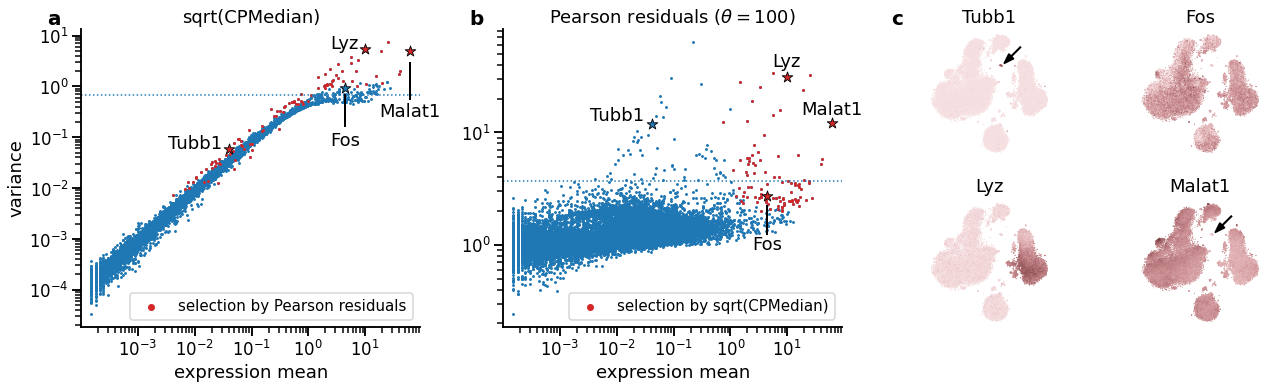

In [19]:
with sns.plotting_context("talk"):
    
    example_genes_idx = np.isin(dataset['genes'],example_genes)

    fig = plt.figure(figsize=(18,6))
    gs = GridSpec(2, 6, figure=fig) 
    
    ax1 = fig.add_subplot(gs[:, 0:2])
    ax2 = fig.add_subplot(gs[:, 2:4])    
    supaxis = fig.add_subplot(gs[:, 4:6])      
    ax3 = fig.add_subplot(gs[0, 4])  
    ax4 = fig.add_subplot(gs[1, 4])  
    ax5 = fig.add_subplot(gs[0, 5])  
    ax6 = fig.add_subplot(gs[1, 5])  
    
    tsne_axes = [ax3,ax4,ax5,ax6]
    tsne_arrows = [(28,39),None,None,(28,39)]
    
    ax1.text(*titleletter_loc,'a',transform=ax1.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax1.set_title('sqrt(CPMedian)')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim((xmin,xmax))
    ax1.set_xlabel(xmean_label)
    ax1.set_ylabel('variance')
    ax1.scatter(gene_means,sqrt_lazy_var,s=dotsize)
    ax1.scatter(gene_means[residuals_variable_genes_idx],sqrt_lazy_var[residuals_variable_genes_idx],color='tab:red',s=dotsize,label='selection by Pearson residuals')
    ax1.scatter(gene_means[residuals_variable_genes_idx & example_genes_idx],sqrt_lazy_var[residuals_variable_genes_idx & example_genes_idx],color='tab:red',s=starsize,marker='*',edgecolors='k',linewidths=staredges)
    ax1.scatter(gene_means[~residuals_variable_genes_idx & example_genes_idx],sqrt_lazy_var[~residuals_variable_genes_idx & example_genes_idx],color='tab:blue',s=starsize,marker='*',edgecolors='k',linewidths=staredges)
    ax1.hlines(sqrt_threshold,xmin,xmax,linestyle=':',linewidth=hline_width)
    
    add_labels(dataset,xdata=gene_means, ydata=sqrt_lazy_var,example_genes=example_genes,textoffsets=example_gene_textoffsets_a,lines=example_gene_lines_a,ax=ax1)
    add_largedot_legend(ax1,'lower right',dict(fontsize=15))
  
    ax2.text(*titleletter_loc,'b',transform=ax2.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax2.set_title(r'Pearson residuals ($\theta=100$)')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim((xmin,xmax))
    ax2.set_xlabel(xmean_label)    
    ax2.scatter(gene_means,residual_var,s=dotsize)
    ax2.scatter(gene_means[sqrt_variable_genes_idx],residual_var[sqrt_variable_genes_idx],color='tab:red',s=dotsize,label='selection by sqrt(CPMedian)')    
    ax2.scatter(gene_means[example_genes_idx & sqrt_variable_genes_idx],residual_var[example_genes_idx & sqrt_variable_genes_idx],color='tab:red',s=starsize,marker='*',edgecolors='k',linewidths=staredges)
    ax2.scatter(gene_means[example_genes_idx & ~sqrt_variable_genes_idx],residual_var[example_genes_idx & ~sqrt_variable_genes_idx],color='tab:blue',s=starsize,marker='*',edgecolors='k',linewidths=staredges)
    ax2.hlines(residuals_threshold,xmin,xmax,linestyle=':',linewidth=hline_width)    

    add_labels(dataset,xdata=gene_means, ydata=residual_var,example_genes=example_genes,textoffsets=example_gene_textoffsets_b,lines=example_gene_lines_b,ax=ax2)
    add_largedot_legend(ax2,'lower right',dict(fontsize=15))    
        
    supaxis.text(*titleletter_loc,'c',transform=supaxis.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)    
    supaxis.axis('off')
    for (tsne_ax,tsne_arrow,example_gene) in zip(tsne_axes,tsne_arrows,example_genes):        
    
        gene_idx = dataset['genes'] == example_gene
        sqrt_lazy_counts = np.squeeze(dataset['sqrt_lazy'][:,gene_idx])
        tsne_ax.set_title(example_gene.lower().capitalize())
        tsne_ax.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1,c=sqrt_lazy_counts, edgecolor='none',cmap=cmap)
        if tsne_arrow:
            tsne_ax.arrow(*tsne_arrow,-8,-8,width=0.5,head_width=6,shape='full',facecolor='k')
        tsne_ax.axis('off')
        
    sns.despine()
    plt.tight_layout()

## Figure S2

In [20]:
### Genes selected by H&S (see Hafemeister & Satija, Figure 4C)
variable_genes_orig = ['TUBB1','CLU','PTGDS','GNG11','SDPR','PF4','PPBP','HIST1H2AC','MZB1','IGJ','IGLL5','GZMB','GNLY','S100A8','NKG7','S100A9','CCL5','LYZ','FTL','FTH1']
variable_genes_orig_idx = np.isin(dataset['genes'],variable_genes_orig)


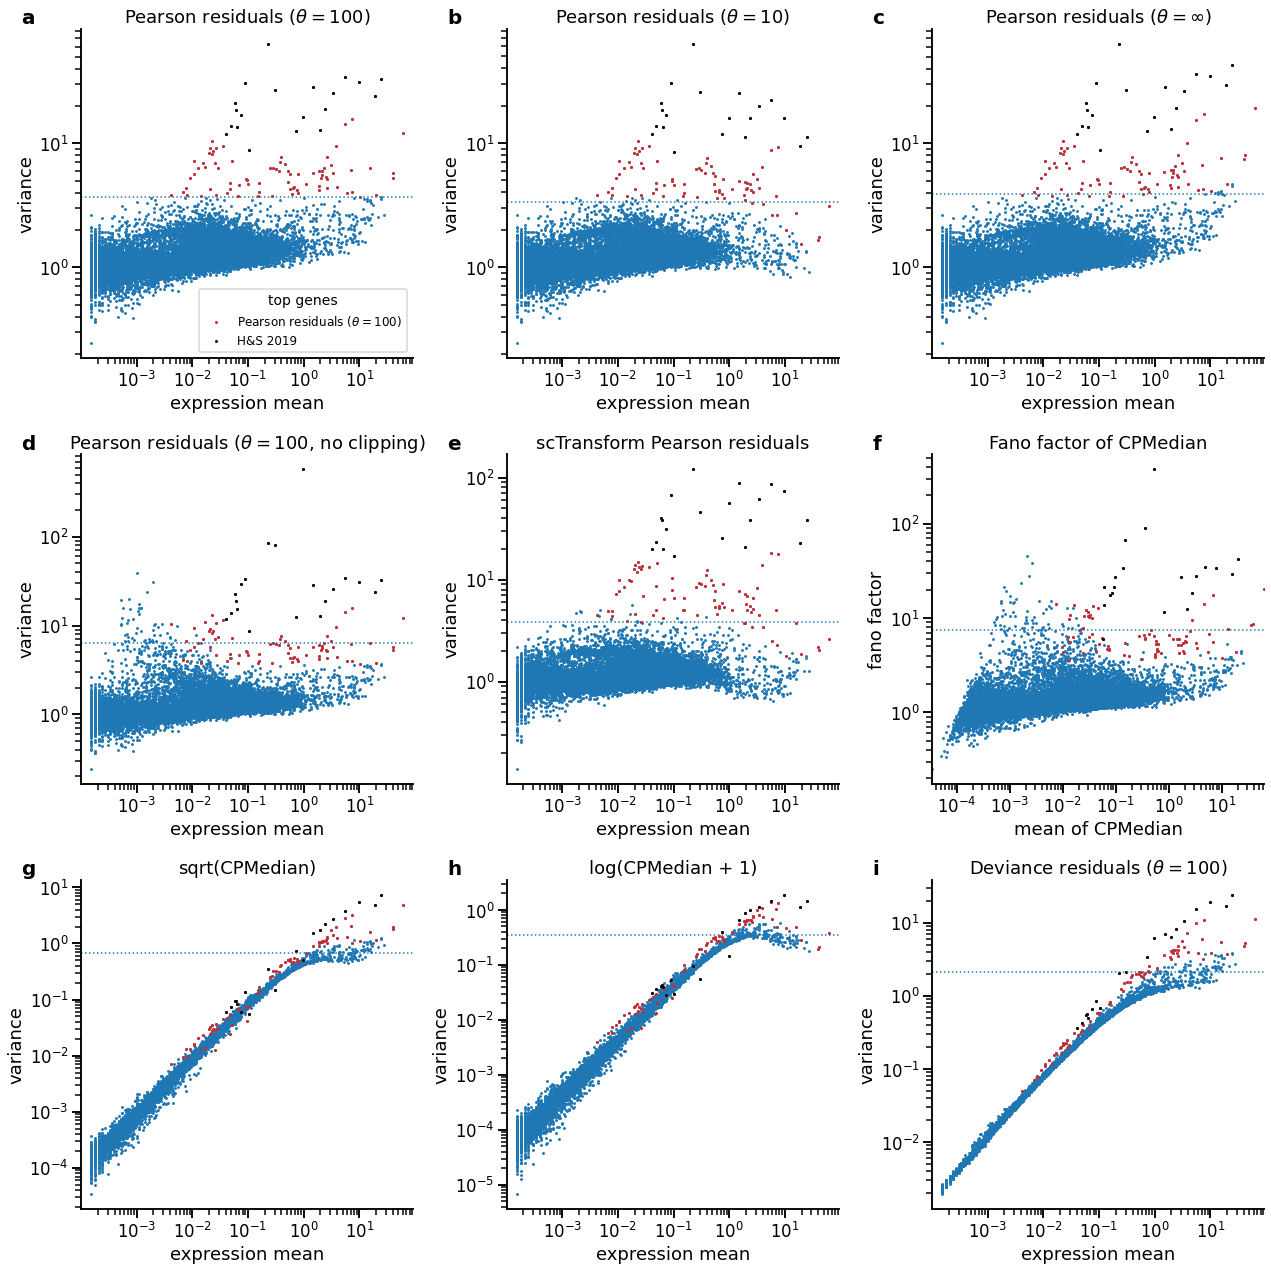

In [21]:
with sns.plotting_context("talk"):
    
    example_genes_idx = np.isin(dataset['genes'],example_genes)

    fig,axes = plt.subplots(3,3,figsize=(18,18))
    
    fano_mean = np.mean(dataset['normalized_medianscale'],axis=0)
    fano = normmedian_var/fano_mean
    fano_threshold = np.sort(fano)[-100]

    
    
    xs = [gene_means,    gene_means,    gene_means,
          gene_means,    gene_means,    fano_mean,
          gene_means,    gene_means, gene_means]
    ys = [residual_var, residual_theta10_var, residual_thetaInf_var,  
          residual_noclip_var, sctresidual_var, fano,
          sqrt_lazy_var, log1p_medianscale_var,devresidual_var,]
    
    hline_ys = [residuals_threshold, residuals_theta10_threshold,residuals_thetaInf_threshold, 
                residuals_noclip_threshold, sctresiduals_threshold, None,
                sqrt_threshold, log1p_medianscale_threshold, devresiduals_threshold]
    
    titles = [r'Pearson residuals ($\theta=100$)', r'Pearson residuals ($\theta=10$)', r'Pearson residuals ($\theta=\infty$)',               
              r'Pearson residuals ($\theta=100$, no clipping)','scTransform Pearson residuals', 'Fano factor of CPMedian',
              'sqrt(CPMedian)',  'log(CPMedian + 1)', r'Deviance residuals ($\theta=100$)',]
    
    letters = ['a','b','c',
               'd','e','f',
               'g','h','i']
    titleletter_loc = (-0.18,1.015)

    
    
    
    for ax,x,y,letter,hline_y,title in zip(axes.flatten(),xs,ys,letters,hline_ys,titles):
        
        ax.text(*titleletter_loc,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        ax.set_title(title)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.scatter(x,y,s=dotsize)
        ax.scatter(x[residuals_variable_genes_idx],y[residuals_variable_genes_idx],color='tab:red',s=dotsize,label='Pearson residuals ' +r'($\theta=100$)')
        ax.scatter(x[variable_genes_orig_idx],y[variable_genes_orig_idx],color='k',s=dotsize,label='H&S 2019')
        
        if letter!='f':
        

            ax.set_xlim((xmin,xmax))
            ax.set_xlabel(xmean_label)
            ax.set_ylabel('variance')
            ax.hlines(hline_y,xmin,xmax,linestyle=':',linewidth=hline_width)

            if letter=='a':
                lng = ax.legend(loc='lower right',fontsize=12,title='top genes',title_fontsize=14)
        else:
            ax.set_xlabel('mean of CPMedian')
            ax.set_ylabel('fano factor')
            ax.hlines(fano_threshold,min(x),max(x),linestyle=':',linewidth=hline_width)
            ax.set_xlim((min(x),max(x)))

    
    sns.despine()
    plt.tight_layout()

# Dimensionality reduction

#### Prepare clustering annotations

In [22]:
#load k means clustering from 10X
k = 10
clusters = np.array(pd.read_csv('datasets/33k_pbmc/analysis/kmeans/10_clusters/clusters.csv')['Cluster'])

#define a mapping from cluster ID to genes (explained in additional plots below)
mapping_clusters2genes = {1:'CD3D+CCR7',       2:'S100A8',    3:'CD3D+GZMK',           4: 'CD3D',                5:'MS4A1',                    6: 'PF4',       7: 'unmarked', 8:'GNLY',       9:'unmarked',       10:'IRF7'}   
#define a mapping cluster ID to our cell type annotations  (explained in additional plots below)
mapping_clusters2typenames = {1:'Naive T cells',   2:'Monocytes', 3:'CD8+mem. T cells', 4: 'CD4+mem. T cells', 5:'Naive+mem. B cells',  6: 'Platelets', 7: 'unmarked', 8:'NK cells',   9:'unmarked', 10:'pDCs'}
marker_offset = {1:[-10,-25],         2:[0,-20],     3: [-20,+8],              4: [3,-30],               5: [+23,-3],                   6: [-5,5],      7: [0,0],      8: [15,0],      9: [0,0],    10: [-2,2]}   


cluster_ids = np.unique(clusters)
cluster_names = [mapping_clusters2typenames[i] for i in cluster_ids]
cluster_genes = [mapping_clusters2genes[i] for i in cluster_ids]

## Figure S4
#### Cluster-colored tSNEs, based on full dataset vs. dataset after gene selection with analytical Pearson residuals

In [23]:
## Load gene selection tSNEs
with open('tsne/tsne_pbmc_maxResSelection_sqrt_lazy_initsqrtLazy.pickle','rb') as f:
    maxResSelection_sqrt_lazy_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_maxResSelection_residuals_theta100_initsqrtLazy.pickle','rb') as f:
    maxResSelection_residuals_theta100_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_maxResSelection_glmpca_nb_thetaFixed100_initsqrtLazy.pickle','rb') as f:
    maxResSelection_glmpca_nb_thetaFixed100_tsne = pickle.load(f)

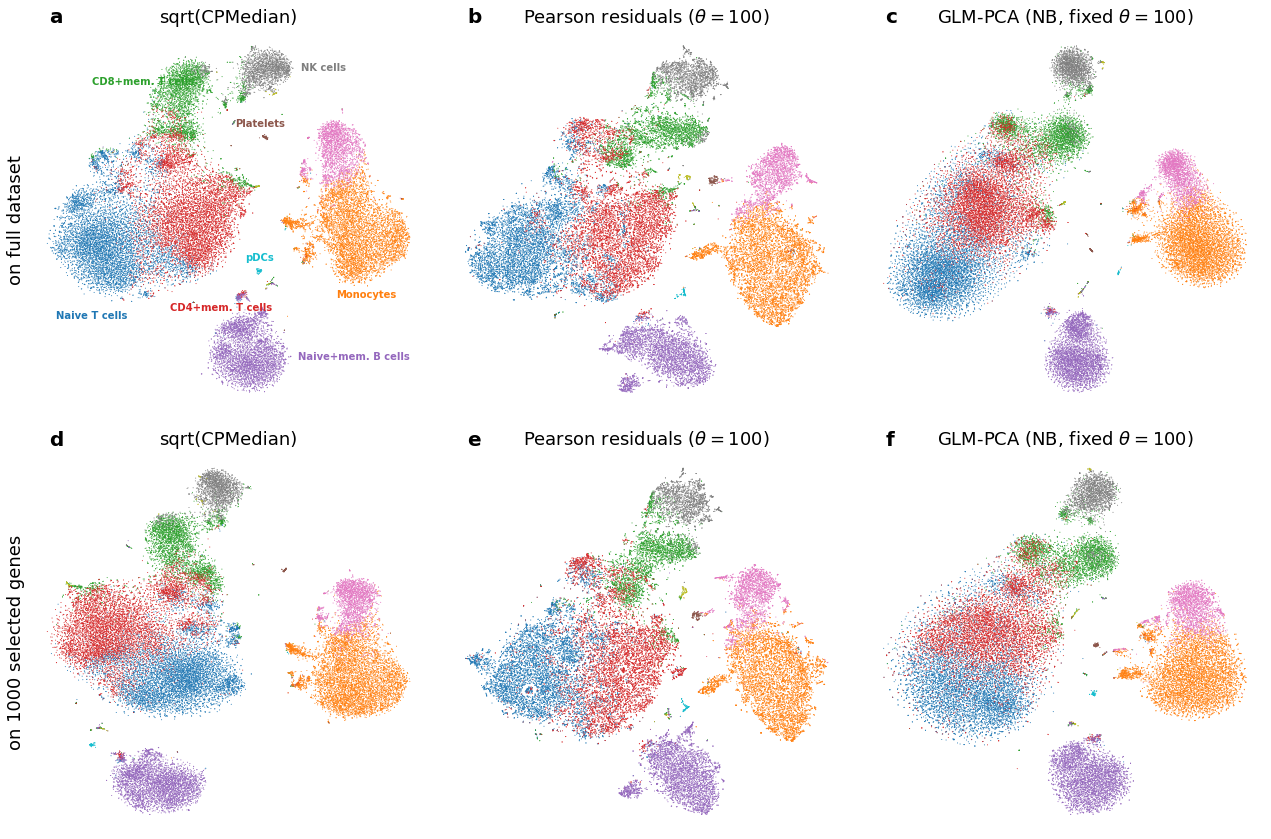

In [24]:
tsnes =  [ sqrt_lazy_tsne,                 residuals_theta100_tsne,                   glmpcaPy_nb_thetaFixed_tsne,
         maxResSelection_sqrt_lazy_tsne,   maxResSelection_residuals_theta100_tsne,   maxResSelection_glmpca_nb_thetaFixed100_tsne]
titles = ['sqrt(CPMedian)', r'Pearson residuals ($\theta=100$)',      r'GLM-PCA (NB, fixed $\theta=100$)',
          'sqrt(CPMedian)', r'Pearson residuals ($\theta=100$)',      r'GLM-PCA (NB, fixed $\theta=100$)',]
ylabels = ['on full dataset','','',
           'on 1000 selected genes','','']
letters = ['a','b','c','d','e','f']

with sns.plotting_context('talk'):
    plt.figure(figsize=(18,12))
    
    for i, (tsne,title,letter,ylabel) in enumerate(zip(tsnes,titles,letters,ylabels)):
        
        plt.subplot(231+i)
        ax=plt.gca()
        plt.text(0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        ax.set_ylabel(ylabel)
    
        for cluster_id in np.unique(clusters):
            cluster_idx = clusters == cluster_id
            

            points=plt.scatter(tsne['coords'][cluster_idx,0], tsne['coords'][cluster_idx,1], s=1, edgecolor='none')
            if i == 0:
                color = points.get_facecolor().flatten()
                if not cluster_id in [9,7]:
                    #compute center of current cluster
                    this_cluster_mean = np.mean(tsne['coords'][cluster_idx,:],axis=0) + marker_offset[cluster_id]
                    #place text
                    plt.text(this_cluster_mean[0]-len(mapping_clusters2typenames[cluster_id])/2,this_cluster_mean[1],mapping_clusters2typenames[cluster_id],fontsize=10,fontweight='bold',color=color)


            plt.tight_layout()
            sns.despine(left=True,bottom=True)

#### Additional tSNEs showing the expression of 10 PBMC cell type marker genes (Wagner, 2020)

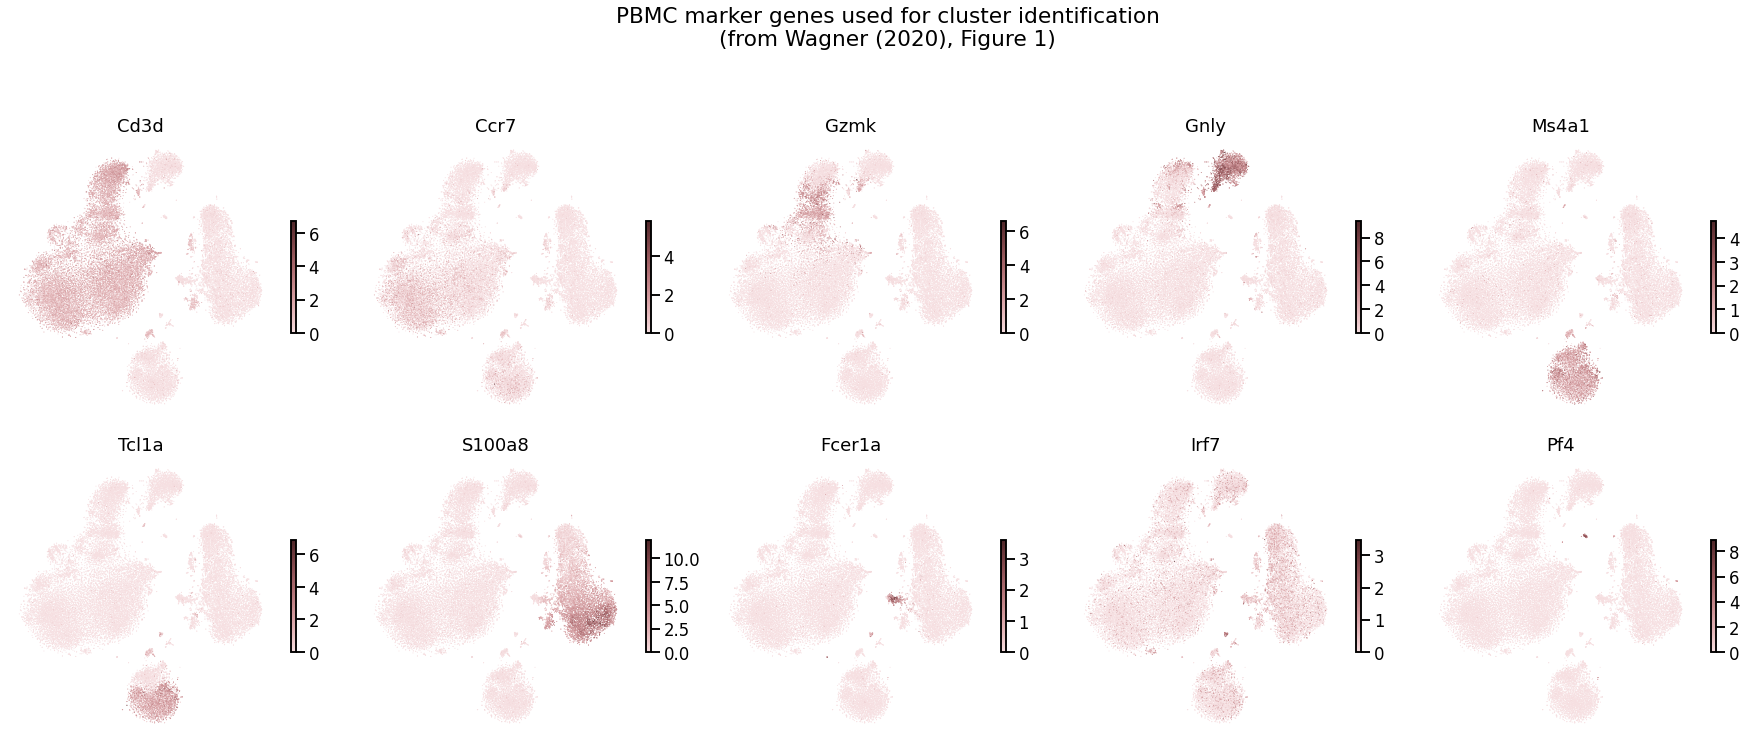

In [26]:
#from Figure 1 of https://www.biorxiv.org/content/10.1101/770388v3.full
marker_genes=['CD3D', 'CCR7', 'GZMK', 'GNLY', 'MS4A1', 'TCL1A', 'S100A8', 'FCER1A', 'IRF7', 'PF4']

with sns.plotting_context('talk'):
    
    fig,axes = plt.subplots(2,5,figsize=(25,10))


    for i,(marker_gene,ax) in enumerate(zip(marker_genes,axes.flatten())):

        gene_idx = dataset['genes'] == marker_gene
        sqrt_counts = np.squeeze(dataset['sqrt_lazy'][:,gene_idx])

        ax.set_title(marker_gene.capitalize())
        sc=ax.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1,c=sqrt_counts, edgecolor='none',cmap=cmap)
        plt.colorbar(sc,ax=ax,shrink=0.4)
        ax.axis('off')
    plt.suptitle('PBMC marker genes used for cluster identification\n(from Wagner (2020), Figure 1)',y=1.04)
    plt.tight_layout()
    sns.despine()

# Downsampling experiment

#### Load metadata of the  downsampled dataset

In [27]:
with open('pbmc_downsampling_experiment_data.pickle','rb') as f:
    downsampling_data = pickle.load(f)

#### Load tSNEs of downsampling experiment

In [28]:
with open('tsne/tsne_pbmc_downsamplingExp_log1p_normalized_scale10k.pickle','rb') as f:    
    log1p10k_downsampling_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_downsamplingExp_log1p_normalized_scaleMedian.pickle','rb') as f:    
    log1pMedian_downsampling_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_downsamplingExp_normalized.pickle','rb') as f:
    normalized_downsampling_tsne = pickle.load(f)    
with open('tsne/tsne_pbmc_downsamplingExp_sqrt_normalized.pickle','rb') as f:    
    sqrt_downsampling_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_downsamplingExp_residuals.pickle','rb') as f:
    residuals_downsampling_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_downsamplingExp_glmpca.pickle','rb') as f:
    glmpca_downsampling_tsne = pickle.load(f)

## Figure S5

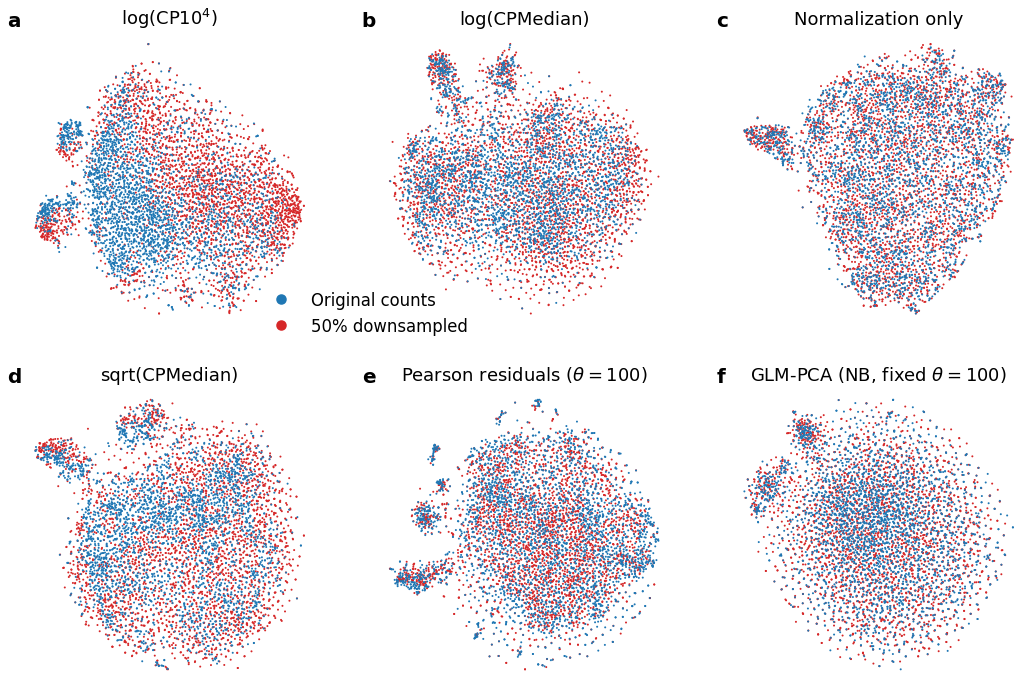

In [29]:

cmap_downsampling = ListedColormap(['tab:blue','tab:red'])

downsampled_idx = downsampling_data['downsampled_idx']
downsampling_labels =  downsampling_data['downsampling_labels']

with sns.plotting_context('talk'):
    fig,axes = plt.subplots(2,3,figsize=(18,12))
    tsnes = [log1p10k_downsampling_tsne,log1pMedian_downsampling_tsne, normalized_downsampling_tsne,
             sqrt_downsampling_tsne, residuals_downsampling_tsne, glmpca_downsampling_tsne]
    labels = [r'log(CP$10^{4}$)', 'log(CPMedian)', 'Normalization only',
             'sqrt(CPMedian)', r'Pearson residuals ($\theta=100$)', r'GLM-PCA (NB, fixed $\theta=100$)']
    letters = ['a','b','c','d','e','f']

    for i,(ax,tsne,label,letter) in enumerate(zip(axes.flatten(),tsnes,labels,letters)):

        plt.text(-0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        scatter = ax.scatter(tsne['coords'][:,0], tsne['coords'][:,1], s=4, edgecolor='none',c=downsampled_idx,cmap=cmap_downsampling)
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i==1:
            ax.legend(handles=scatter.legend_elements()[0],labels=downsampling_labels,frameon=False,loc=(-0.4,-0.05))
        
        
    sns.despine(left=True,bottom=True)

#### Additional plot: Figure S5 with depth coloring

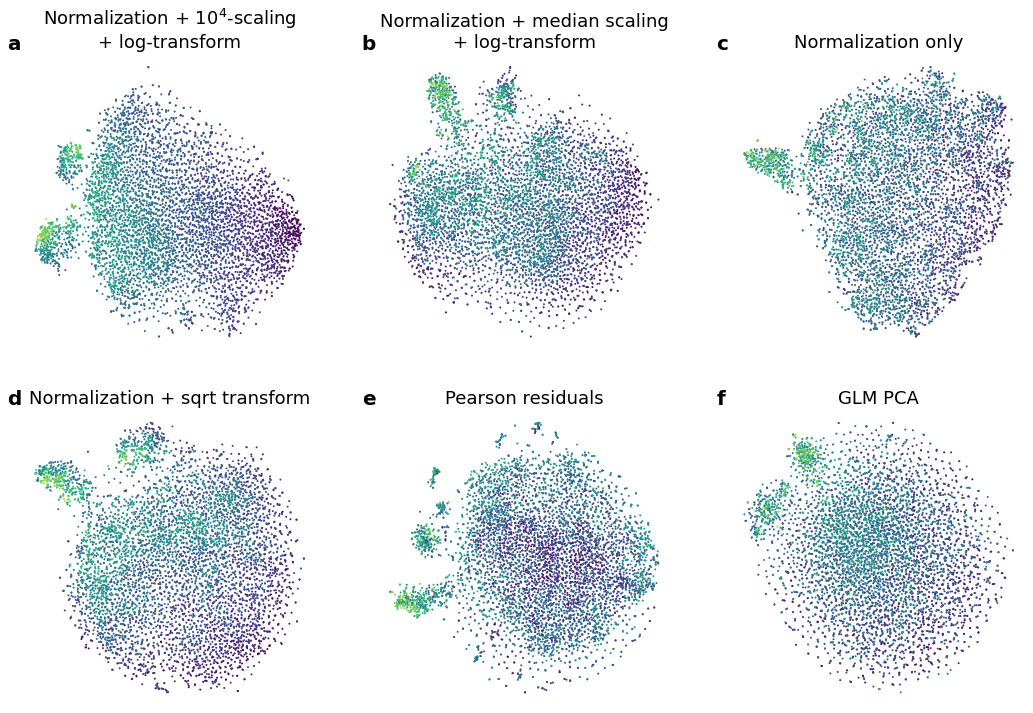

In [30]:
with sns.plotting_context('talk'):
    fig,axes = plt.subplots(2,3,figsize=(18,12))
    tsnes = [log1p10k_downsampling_tsne,log1pMedian_downsampling_tsne, normalized_downsampling_tsne,
             sqrt_downsampling_tsne, residuals_downsampling_tsne, glmpca_downsampling_tsne]
    labels = [r'Normalization + $10^{4}$-scaling' '\n+ log-transform', 'Normalization + median scaling\n+ log-transform', 'Normalization only',
             'Normalization + sqrt transform', 'Pearson residuals', 'GLM PCA']
    letters = ['a','b','c','d','e','f']

    for i,(ax,tsne,label,letter) in enumerate(zip(axes.flatten(),tsnes,labels,letters)):

        plt.text(-0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        scatter = ax.scatter(tsne['coords'][:,0], tsne['coords'][:,1], s=4, edgecolor='none',c=np.sqrt(downsampling_data['depths']))
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])
        
    sns.despine(left=True,bottom=True)

#### Additional plot: tSNEs indentifying cluster #2 with CD14-positive monocytes

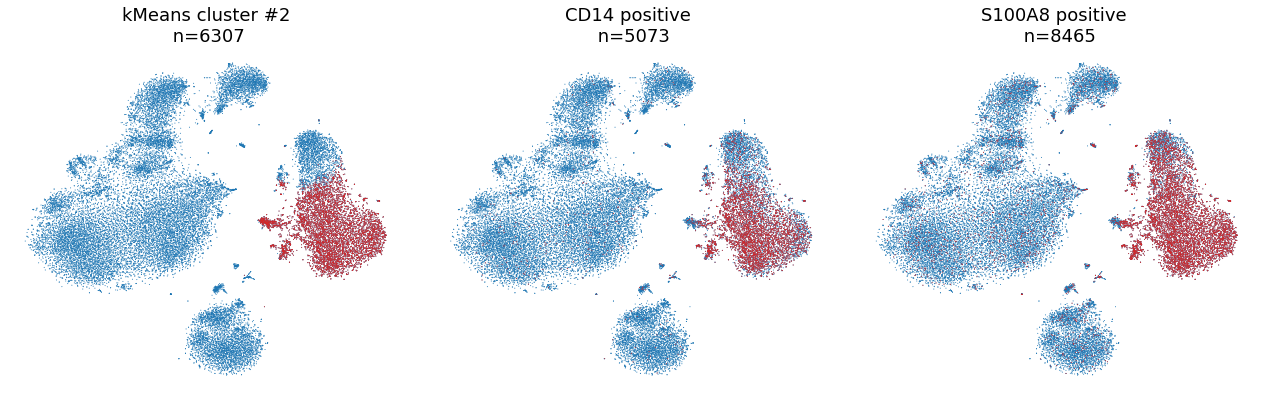

In [31]:
## compare kmeans cluster #2 with published monocyte markers
cd14_idx = (dataset['genes']=='CD14')
cd14 = np.squeeze(counts[:,cd14_idx])
cd14_positive_idx = cd14>0

monocytemarker_idx = (dataset['genes']=='S100A8')
monocytemarker_counts = np.squeeze(counts[:,monocytemarker_idx])
monocytemarker_positive_idx = monocytemarker_counts>0

#plot CD14 expression map and cluster 2 map
with sns.plotting_context('talk'):
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1, edgecolor='none')
    plt.scatter(sqrt_lazy_tsne['coords'][clusters==2,0], sqrt_lazy_tsne['coords'][clusters==2,1], c="tab:red",s=1, edgecolor='none')
    plt.title('kMeans cluster #2\n n=%u'%(sum(clusters==2)))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(132)
    plt.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1, edgecolor='none')
    plt.scatter(sqrt_lazy_tsne['coords'][cd14_positive_idx,0], sqrt_lazy_tsne['coords'][cd14_positive_idx,1], c="tab:red",s=1, edgecolor='none')
    plt.title('CD14 positive \n n=%u'%(sum(cd14_positive_idx)))

    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(133)
    plt.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1, edgecolor='none')
    plt.scatter(sqrt_lazy_tsne['coords'][monocytemarker_positive_idx,0], sqrt_lazy_tsne['coords'][monocytemarker_positive_idx,1], c="tab:red",s=1, edgecolor='none')
    plt.title('S100A8 positive \n n=%u'%(sum(monocytemarker_positive_idx)))

    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    sns.despine(left=True,bottom=True)

## Figure S6
#### Depth-colored tSNE embeddings

<ipython-input-32-58866ac3e798>:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


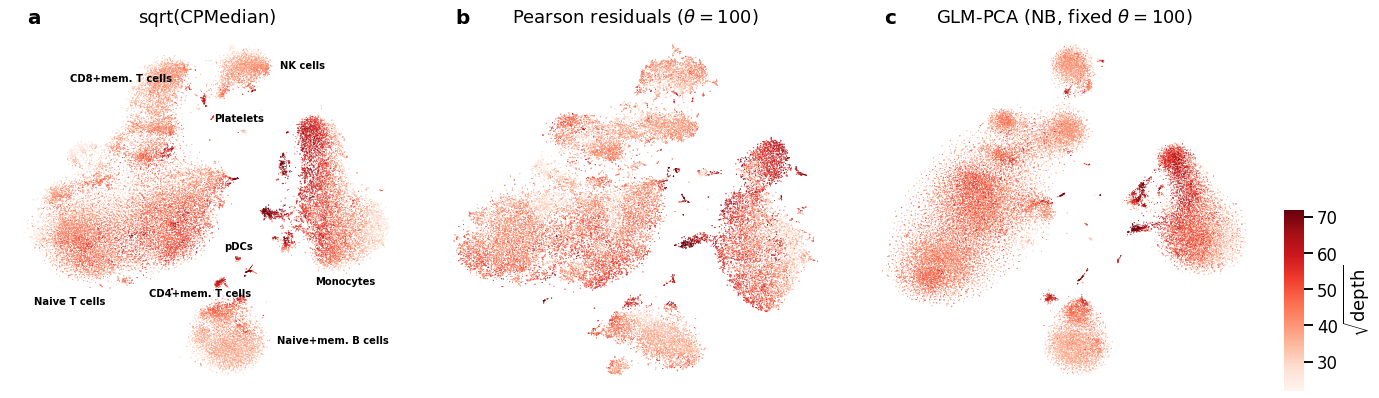

In [32]:
depths = np.squeeze(np.array(np.sum(counts,axis=1)))
sqrtdepths = np.sqrt(depths)

tsnes =  [ sqrt_lazy_tsne,                 residuals_theta100_tsne,  glmpcaPy_nb_thetaFixed_tsne]
titles = ['sqrt(CPMedian)', r'Pearson residuals ($\theta=100$)', r'GLM-PCA (NB, fixed $\theta=100$)']
letters = ['a','b','c']

with sns.plotting_context('talk'):
    plt.figure(figsize=(18,6))
    
    for i, (tsne,title,letter) in enumerate(zip(tsnes,titles,letters)):
        
        plt.subplot(131+i)
        ax=plt.gca()
        plt.text(0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

        plt.scatter(tsne['coords'][:,0], tsne['coords'][:,1], s=1, edgecolor='none',c=np.sqrt(depths),cmap='Reds',vmax=72)
        if i==2:
            #make colorbar
            ax=plt.gca()
            axins1 = inset_axes(ax,
                                 width="5%",  
                                 height="50%", 
                                 loc=('lower left'),
                                 bbox_to_anchor=(1.05, 0., 1, 1),
                                 bbox_transform=ax.transAxes,
                                 borderpad=0)

            cb = plt.colorbar(cax=axins1, orientation="vertical",ticks=[20,30,40,50,60,70])
            axins1.set_ylabel(r'$\sqrt{\mathrm{depth}}$')
            cb.outline.set_visible(False)

        if i == 0:
            
            for cluster_id in np.unique(clusters):
                cluster_idx = clusters == cluster_id
                if not cluster_id in [9,7]:
                    #compute center of current cluster
                    this_cluster_mean = np.mean(tsne['coords'][cluster_idx,:],axis=0) + marker_offset[cluster_id]
                    #place text
                    plt.text(this_cluster_mean[0]-len(mapping_clusters2typenames[cluster_id])/2,this_cluster_mean[1],mapping_clusters2typenames[cluster_id],fontsize=10,fontweight='bold')


        plt.tight_layout()
        sns.despine(left=True,bottom=True)

In [2]:
%load_ext watermark

In [3]:
watermark

Last updated: 2021-05-21T18:35:54.812515+02:00

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.21.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 3.10.0-957.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [4]:
watermark --iversions

anndata   : 0.7.5
seaborn   : 0.11.1
matplotlib: 3.3.3
numpy     : 1.20.1
pandas    : 1.2.0

